In [5]:
import os
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from pyvi import ViTokenizer
from vietnam_number import n2w
import chardet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import text_to_word_sequence
import pickle
import h5py

In [6]:
# load file vietnamese stop words
# source: # https://github.com/stopwords/vietnamese-stopwords/blob/master/vietnamese-stopwords.txt

def load_stopwords(filepath):
    with open(filepath, 'r', encoding='utf-8') as f:
        stop_words = set(f.read().splitlines())
    return stop_words

# Nomalize text
def normalize_text(text):
    text = text.lower()
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'(\d+)', '<number>', text)
    return text

# Vietnamese text normalization specifically for handling diacritics and special characters
def normalize_vietnamese_text(text):
    text = ViTokenizer.tokenize(text)
    text = text.replace(' ', '')
    text = re.sub(r'\u200B', '', text)
    return text

# Convert numbers to words
def lemmatize_numbers(text):
    text = re.sub(r'(\d+)', lambda x: n2w(x.group()), text)
    return text

# Tokenize Vietnamese text
def tokenize_vietnamese_text(text):
    tokens = ViTokenizer.tokenize(text)
    return tokens

# Preprocessing
def preprocess_text(text, stop_words):
    text = normalize_text(text)
    text = normalize_vietnamese_text(text)
    text = lemmatize_numbers(text)
    text = tokenize_vietnamese_text(text)
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

# Load data from subfolders where each subfolder represents a topic
def load_data_from_folders(root_folder, stop_words):
    texts = []
    labels = []
    
    topics = os.listdir(root_folder)
    for topic in topics:
        topic_folder = os.path.join(root_folder, topic)
        if os.path.isdir(topic_folder):
            for file in os.listdir(topic_folder):
                file_path = os.path.join(topic_folder, file)
                with open(file_path, 'rb') as f:
                    raw_data = f.read()
                    result = chardet.detect(raw_data)
                    encoding = result['encoding']

                with open(file_path, 'r', encoding=encoding) as f:
                    text = f.read()
                    text = preprocess_text(text, stop_words)
                    texts.append(text)
                    labels.append(topic)

    return texts, labels

# Augment data for classes with fewer samples
def augment_data(texts, labels, target_size, stop_words):
    unique_labels, label_counts = np.unique(labels, return_counts=True)
    max_count = np.max(label_counts)
    for label in unique_labels:
        if label_counts[unique_labels == label][0] < target_size:
            to_augment = target_size - label_counts[unique_labels == label][0]
            idx_to_copy = np.random.choice(np.where(np.array(labels) == label)[0], to_augment)
            for idx in idx_to_copy:
                augmented_text = preprocess_text(texts[idx], stop_words)
                texts.append(augmented_text)
                labels.append(label)
    return texts, labels

In [7]:
# Load stopwords
stopwords_filepath = 'vietnamese-stopwords.txt'
stop_words = load_stopwords(stopwords_filepath)

In [8]:
# Folders path
train_folder = r'dataset\Train_Full'
test_folder = r'dataset\Test_Full'

In [9]:
# Load and preprocess train and test data
train_texts, train_labels = load_data_from_folders(train_folder, stop_words)
test_texts, test_labels = load_data_from_folders(test_folder, stop_words)

In [10]:
# Combine data
all_texts = train_texts + test_texts
all_labels = train_labels + test_labels

In [11]:
# Calculate label frequencies for augmentation
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(all_labels)
unique_labels, label_counts = np.unique(encoded_labels, return_counts=True)

In [12]:
# Apply augmentation to smaller classes
augmented_texts, augmented_labels = augment_data(all_texts, all_labels, max(label_counts), stop_words)


In [13]:
# Re-encode augmented labels
encoded_augmented_labels = label_encoder.fit_transform(augmented_labels)

In [14]:
# Split data into train, test, valid
x_train, x_temp, y_train, y_temp = train_test_split(augmented_texts, encoded_augmented_labels, test_size=0.3, stratify=encoded_augmented_labels)
x_test, x_valid, y_test, y_valid = train_test_split(x_temp, y_temp, test_size=0.2, stratify=y_temp)

In [15]:
# Tokenization: Convert text data into numerical sequences
max_words = 10000
maxlen = 200
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(x_train)

x_train_seq = pad_sequences(tokenizer.texts_to_sequences(x_train), maxlen=maxlen)
x_test_seq = pad_sequences(tokenizer.texts_to_sequences(x_test), maxlen=maxlen)
x_valid_seq = pad_sequences(tokenizer.texts_to_sequences(x_valid), maxlen=maxlen)

y_train = np.array(y_train)
y_test = np.array(y_test)
y_valid = np.array(y_valid)

In [16]:
# Build the model
model = Sequential()
model.add(Embedding(max_words, 128, input_length=maxlen))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(x_train_seq, y_train, batch_size=32, epochs=10, validation_data=(x_valid_seq, y_valid))

# Save the model
model.save('text_classification_model_augmented.h5')

Epoch 1/10


c:\Users\NTN8HC\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


2797/2797 ━━━━━━━━━━━━━━━━━━━━ 285s 101ms/step - accuracy: 0.4850 - loss: 1.4871 - val_accuracy: 0.7942 - val_loss: 0.6645
Epoch 2/10
2797/2797 ━━━━━━━━━━━━━━━━━━━━ 288s 103ms/step - accuracy: 0.8284 - loss: 0.5925 - val_accuracy: 0.8253 - val_loss: 0.5718
Epoch 3/10
2797/2797 ━━━━━━━━━━━━━━━━━━━━ 436s 156ms/step - accuracy: 0.8766 - loss: 0.4278 - val_accuracy: 0.8381 - val_loss: 0.5390
Epoch 4/10
2797/2797 ━━━━━━━━━━━━━━━━━━━━ 766s 274ms/step - accuracy: 0.9044 - loss: 0.3330 - val_accuracy: 0.8472 - val_loss: 0.5482
Epoch 5/10
2797/2797 ━━━━━━━━━━━━━━━━━━━━ 272s 97ms/step - accuracy: 0.9222 - loss: 0.2674 - val_accuracy: 0.8534 - val_loss: 0.5581
Epoch 6/10
2797/2797 ━━━━━━━━━━━━━━━━━━━━ 267s 95ms/step - accuracy: 0.9337 - loss: 0.2216 - val_accuracy: 0.8531 - val_loss: 0.5931
Epoch 7/10
2797/2797 ━━━━━━━━━━━━━━━━━━━━ 255s 91ms/step - accuracy: 0.9450 - loss: 0.1859 - val_accuracy: 0.8573 - val_loss: 0.6296
Epoch 8/10
2797/2797 ━━━━━━━━━━━━━━━━━━━━ 259s 92ms/step - accuracy: 0.9532 

- Epoch 1: Mô hình bắt đầu với accuracy là 48.50% vàloss là 1.4871. Khởi đầu với hiệu thấp, mô hình cần thời gian và dữ liệu để học.
- Qua các Epoch Tiếp Theo: Từ Epoch 2 đến Epoch 10, accuracy đã tăng lên 96.27% và loss giảm xuống còn 0.1209 => mô hình đang học tốt từ tập train.

In [17]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(x_test_seq, y_test, verbose=2)
print(f'Test accuracy: {test_acc:.4f}')

959/959 - 31s - 32ms/step - accuracy: 0.8620 - loss: 0.7558
Test accuracy: 0.8620


-  Accuracy trên tập train cao hơn nhiều so với tập test (96.27% so với 86.20%) => overfitting (không quá nghiêm trọng)

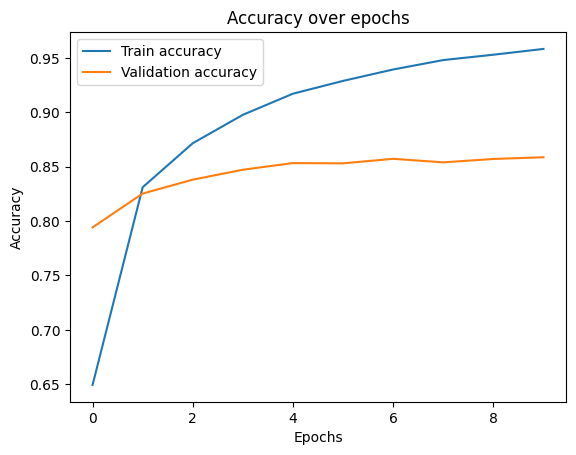

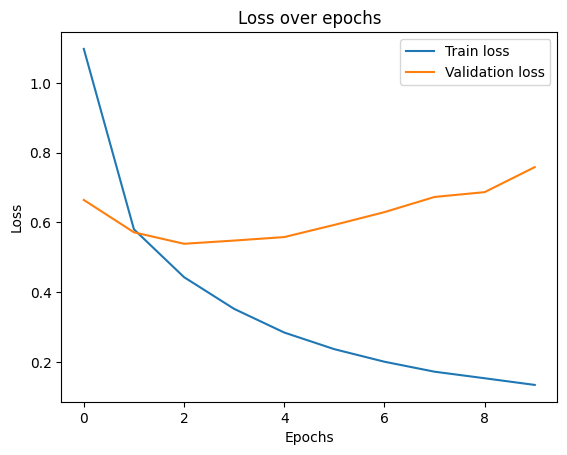

In [19]:
# Plot training history
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


- Train accuracy tăng trưởng liên tục và mạnh mẽ (từ khoảng 48.5% ở Epoch 1 đến gần 96.27% ở Epoch 10). => Mô hình đang học tốt từ tập train.
- Test accuracy có xu hướng tăng, nhưng mức tăng chậm hơn và dừng lại ở khoảng 85.87%. 

- Từ khoảng epoch 5 trở đi: có khoảng cách rõ rệt giữa Train accuracy và Test accuracy, đặc biệt ở các epoch sau (từ khoảng epoch 5 trở đi). Mô hình có thể đã học được nhiều thông tin từ tập train, nhưng việc tổng quát cho tập test vẫn cần cải thiện. (Cần theo dõi tiếp để check tính ổn định của mô hình)


- Từ epoch đầu tiên tới epoch 2, loss giảm mạnh với tập train, và giảm liên tục đến epoch cuối => Mô hình đang học tốt từ tập train, có cải thiện hiệu suất theo thời gian.
- Loss trên tập test không giảm đều và ổn định như tập train.

In [21]:
# Print out original text and model output for manual check
for i in range(5):
    original_text = x_valid[i]
    predicted_label = label_encoder.inverse_transform([np.argmax(model.predict(np.expand_dims(x_valid_seq[i], axis=0)))])
    print(f"Original: {original_text}, Predicted: {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
Original: virusđãthực_sựđe_dọađiện_thoại_di_độngnhữngđoạnmãnguy_hiểmxóa_sạchdanh_bạtinnhắnráclấpđầybộ_nhớnhữngvịkháchkhôngmờikhóưatự_doxâm_nhậplàđiềungườidùngđtdđđượccảnh_báobấy_lâu_nayliệuvirusđiện_thoạiđãthực_sựlàmộtnguy_cơkhủng_khiếpnhưmọingườivẫnnghĩtheonhận_địnhcủacácchuyên_giavềanhninhvàbảo_mậtđtdđchắc_chắnsẽlàđíchđếncủanhữngtai_hoạđại_loạinhưtrêncuộcchiến_đấuvớivirusđiện_thoạicũngsẽkhó_khănvànguy_hiểmnhưviệcngăn_chặnsựlây_lancủacăn_bệnhđậu_mùatuy_nhiêntình_hìnhhiện_tạichưađếnmứcphảihoảng_sợbởicómộtđiềurõ_ràngrằngmọithứvẫncònđangnằmtrongphòngthí_nghiệmchúng_tôichưanhậnđượcbất_kỳphản_ánhnàocủangườidùngđiện_thoạivềviệcbịvirusquấy_nhiễugrahamcluleycố_vấnkỹ_thuậtcủahãngbảo_mậtsophosanhchobiết_điềuduy_nhấtmàchúng_tôitừngđượcbiếtlàcácnhànghiên_cứuđãtrao_đổivirusvớinhauchỉtrongphòngthí_nghiệmmàthôituy_vậynhiềucông_tyvẫnlấyphương_châmcẩn_tắcvôưunttdocomonhàsản_xuấtđiện_thoạihàng_đầucủanhậtbảnđãsẵn_sàngbánrasản_phẩmđượctích_hợp_phần_mềmchốngviruscủam